In [17]:
from __future__ import division, print_function
import os
import sys
import numpy as np
import pandas as pd
import src.preprocessing as preprocessing
from src.preprocessing import preprocess, preprocess_players, polynomial_features
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, Lasso
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
import warnings
from sklearn.preprocessing import PolynomialFeatures
from src.build_db import connect
from src.db_helpers import parse_date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from scipy.sparse import coo_matrix, csc_matrix, hstack
from collections import defaultdict
warnings.filterwarnings("ignore")

In [2]:
# connect to db
db_name = 'dota_db'
with open(os.path.expanduser('~/.pgpass')) as f:
    for line in f:
        host, port, db, user, password = [x.strip() for x in line.split(':')]
        if db == db_name:
            dota_con, meta = connect(user=user, password=password, db=db, host=host, port=port)
            break


In [4]:
query = '''
SELECT DISTINCT ON(match_id) match_id, players, radiant_win FROM match_history WHERE duration >= 900;
'''
df = pd.read_sql(query, dota_con)
df = preprocess_players(df)

In [7]:
y = df['radiant_win'].values
X = df.drop(['radiant_win', 'match_id'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5000)
X_poly_train = polynomial_features(X_train)
X_poly_test = polynomial_features(X_test)
X_poly = polynomial_features(X)

# Learning Rate

In [20]:
def my_cross_val(est, X, y, train_size=None):
    scores = []
    for i in xrange(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5000)
        while True:
            try:
                if train_size:
                    X_train, y_train = shuffle(X_train, y_train)
                    X_train = X_train[:train_size, :]
                    y_train = y_train[:train_size]
                est.fit(X_train, y_train)
            except:
                continue
            break
        scores.append(est.score(X_test, y_test))
    return scores
        

In [27]:
def polynomial_logreg(train_size):
    est = LogisticRegression(C=.1)
    return np.mean(my_cross_val(est, X_poly, y, train_size))
def polynomial_ridge(train_size):
    est = RidgeClassifier(alpha=1000)
    return np.mean(my_cross_val(est, X_poly, y, train_size))
def logreg(train_size):
    est = LogisticRegression(C=.1)
    return np.mean(my_cross_val(est, X, y, train_size))
def ridge(train_size):
    est = RidgeClassifier(alpha=1000)
    return np.mean(my_cross_val(est, X, y, train_size))
def rf(train_size):
    est = RandomForestClassifier(n_estimators=500)
    return np.mean(my_cross_val(est, X, y, train_size))
def xgb(train_size):
    est = XGBClassifier(n_estimators=1000)
    return np.mean(my_cross_val(est, X, y, train_size))

In [69]:
training_sizes = []
test_scores = defaultdict(list)
training_size = 4
models = {'pf_logreg': polynomial_logreg, 'pf_ridge': polynomial_ridge,
          'random_forest': rf, 'logreg': logreg, 'ridge': ridge, 'xgb': xgb}
while training_size <= X_train.shape[0]:
    training_sizes.append(training_size)
    for model_name, model in models.iteritems():
        score = model(training_size)
        test_scores[model_name].append(score)
    training_size = 2 * training_size

In [70]:
training_sizes.append(X_train.shape[0])
for model_name, model in models.iteritems():
    score = model(None)
    test_scores[model_name].append(score)

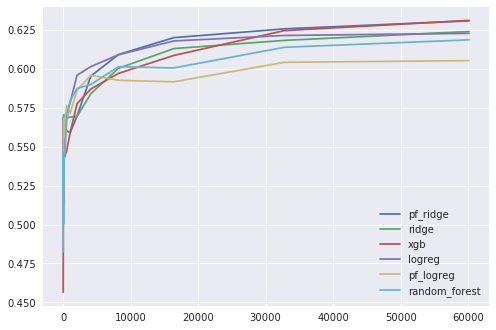

In [71]:
fig, ax = plt.subplots()
for model_name, scores in test_scores.iteritems():
    ax.plot(training_sizes, scores, label=model_name)
ax.legend()
plt.show()